In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import datetime
import os

In [5]:
import pandas as pd 

data_cox = pd.read_csv('data/data_cox_with_survival3yr.csv')
data_cox.head()

,CD74,HLA-DPB1,HLA-DRB1,HLA-DMA,HLA-DMB,HLA-DRA,HLA-DPA1,HLA-DOA,HLA-E,HLA-DQA1,...,LCP2,SERPING1,CD4,FCER1G,C1QB,C1QC,overall_survival,status,risk_score,survival_3yr
0,12.5668,8.6102,8.7590,8.5993,8.9834,10.7880,8.8908,6.8782,12.2597,6.8204,...,7.6154,8.2515,10.1129,9.4675,11.3329,11.2728,3574.0,False,-0.291393,1
1,15.4927,11.9222,12.3668,10.5364,10.8081,13.9021,12.5162,10.0694,13.9244,10.2799,...,9.0451,11.8442,10.8098,9.7941,12.5445,12.4334,234.0,True,1.282886,0
2,15.3739,11.4483,12.7477,10.5580,10.8706,13.7942,11.9650,10.3466,13.7275,10.4735,...,9.2850,9.8687,11.6573,10.0406,13.3568,13.2014,1335.0,True,-0.699702,1
3,13.2865,10.4928,9.8587,9.0924,9.5139,11.8657,10.5019,8.5010,11.6388,8.4154,...,7.9089,7.9684,10.2035,8.4250,11.8849,11.9314,1106.0,True,-0.937324,1
4,14.4549,11.6700,11.6364,10.3967,9.8603,13.2601,11.5003,9.0541,12.5336,9.8875,...,6.9549,10.4694,9.5651,8.9940,11.4629,11.5642,1828.0,False,0.119908,1


In [6]:
# Columnas que no son genes hub a excluir
exclude_cols = ['overall_survival', 'status', 'risk_score', 'survival_3yr']

# Lista de genes hub: todas las columnas salvo las clínicas (de expresión génica)
top_hubs_in_expr = [col for col in data_cox.columns if col not in exclude_cols]

print(f"Número de genes hub utilizados: {len(top_hubs_in_expr)}")
print(top_hubs_in_expr)

Número de genes hub utilizados: 25
['CD74', 'HLA-DPB1', 'HLA-DRB1', 'HLA-DMA', 'HLA-DMB', 'HLA-DRA', 'HLA-DPA1', 'HLA-DOA', 'HLA-E', 'HLA-DQA1', 'PTPRC', 'LYN', 'IL10', 'CD3E', 'FCGR3A', 'LCK', 'CASP1', 'CD2', 'B2M', 'LCP2', 'SERPING1', 'CD4', 'FCER1G', 'C1QB', 'C1QC']


## Modelos de red neural y random forest con datos reales y sintéticos 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from ctgan import CTGAN
import numpy as np

# 1. Separar set real en train y test (ej. 80%-20%)
train_df, test_df = train_test_split(data_cox, test_size=0.2, stratify=data_cox['survival_3yr'], random_state=42)

# 2. Definir variables gen hub en train y test
X_train_df = train_df[top_hubs_in_expr + ['survival_3yr']].copy()
X_test_df = test_df[top_hubs_in_expr + ['survival_3yr']].copy()  # no incluyo datos sintéticos en test

# 3. Entrenar CTGAN solo con train_df
ctgan = CTGAN(epochs=300, verbose=True)
ctgan.fit(X_train_df)

# 4. Generar datos sintéticos
num_synthetic = len(X_train_df) * 2
synthetic_data = ctgan.sample(num_synthetic)

# 5. Concatenar datos reales de train + sintéticos para entrenamiento aumentado
train_augmented_df = pd.concat([X_train_df, synthetic_data], ignore_index=True)

# Convertir a numpy arrays para modelos
X_train = train_augmented_df[top_hubs_in_expr].values.astype(np.float32)
y_train = train_augmented_df['survival_3yr'].values.astype(int)

X_test = X_test_df[top_hubs_in_expr].values.astype(np.float32)
y_test = X_test_df['survival_3yr'].values.astype(int)

Gen. (-1.16) | Discrim. (0.00): 100%|██████████| 300/300 [00:25<00:00, 11.56it/s] 


In [8]:
# 6. Entrenamiento del modelo (ejemplo Random Forest + SMOTETomek con CV en train)

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

pipeline = Pipeline([
    ('smotetomek', SMOTETomek(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pipeline.fit(X_tr, y_tr)
    y_val_proba = pipeline.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    auc_scores.append(auc)
    print(f"Fold {fold} AUC (train CV): {auc:.4f}")

print(f"AUC promedio (train CV): {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# 7. Evaluar modelo final refit entrenado en todo train_augmented_df

pipeline.fit(X_train, y_train)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC en TEST real no visto: {auc_test:.4f}")


Fold 1 AUC (train CV): 0.5897
Fold 2 AUC (train CV): 0.4828
Fold 3 AUC (train CV): 0.5845
Fold 4 AUC (train CV): 0.5718
Fold 5 AUC (train CV): 0.5215
AUC promedio (train CV): 0.5500 ± 0.0414

AUC en TEST real no visto: 0.5793


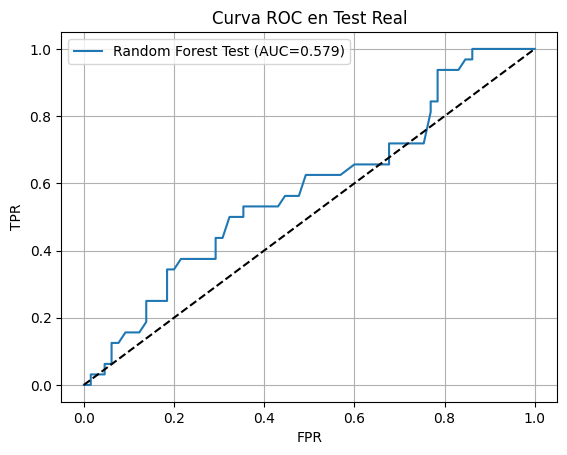

In [9]:
# Opcional: graficar curva ROC en test real
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'Random Forest Test (AUC={auc_test:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC en Test Real')
plt.legend()
plt.grid()
plt.show()

### Red Neural

Entrenando CTGAN...


Gen. (-2.56) | Discrim. (0.18): 100%|██████████| 1000/1000 [01:30<00:00, 11.07it/s]



Fold 1
Epoch 1/1000


d:\Coding\investigacionIA\entorno\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8734
Epoch 2/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6981
Epoch 3/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6881
Epoch 4/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6817
Epoch 5/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6760
Epoch 6/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6734
Epoch 7/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6679
Epoch 8/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6649
Epoch 9/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6599
Epoch 10/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6605
Epoch 11/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6587
Epoch 12/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6516
Epoch 13/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6496
Epoch 14/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6479
Epoch 15/1000
224/224 ━━━━━━━━━━━━━━━━━━━━

d:\Coding\investigacionIA\entorno\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8265
Epoch 2/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6960
Epoch 3/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6901
Epoch 4/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6779
Epoch 5/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6691
Epoch 6/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6644
Epoch 7/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6646
Epoch 8/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6613
Epoch 9/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6538
Epoch 10/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6501
Epoch 11/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6419
Epoch 12/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6442
Epoch 13/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6420
Epoch 14/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6379
Epoch 15/1000
224/224 ━━━━━━━━━━━━━━━━━━━━

d:\Coding\investigacionIA\entorno\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8629
Epoch 2/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6989
Epoch 3/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6911
Epoch 4/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6850
Epoch 5/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6801
Epoch 6/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6768
Epoch 7/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6719
Epoch 8/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6691
Epoch 9/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6656
Epoch 10/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6628
Epoch 11/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6669
Epoch 12/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6574
Epoch 13/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6578
Epoch 14/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6541
Epoch 15/1000
224/224 ━━━━━━━━━━━━━━━━━━━━

d:\Coding\investigacionIA\entorno\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9234
Epoch 2/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6912
Epoch 3/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6824
Epoch 4/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6787
Epoch 5/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6690
Epoch 6/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6667
Epoch 7/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6672
Epoch 8/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6613
Epoch 9/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6579
Epoch 10/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6535
Epoch 11/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6509
Epoch 12/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6541
Epoch 13/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6487
Epoch 14/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6408
Epoch 15/1000
224/224 ━━━━━━━━━━━━━━━━━━━━

d:\Coding\investigacionIA\entorno\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9344
Epoch 2/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6945
Epoch 3/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6786
Epoch 4/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6714
Epoch 5/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6730
Epoch 6/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6692
Epoch 7/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6604
Epoch 8/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6602
Epoch 9/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6557
Epoch 10/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6493
Epoch 11/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6469
Epoch 12/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6476
Epoch 13/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6446
Epoch 14/1000
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6414
Epoch 15/1000
224/224 ━━━━━━━━━━━━━━━━━━━━

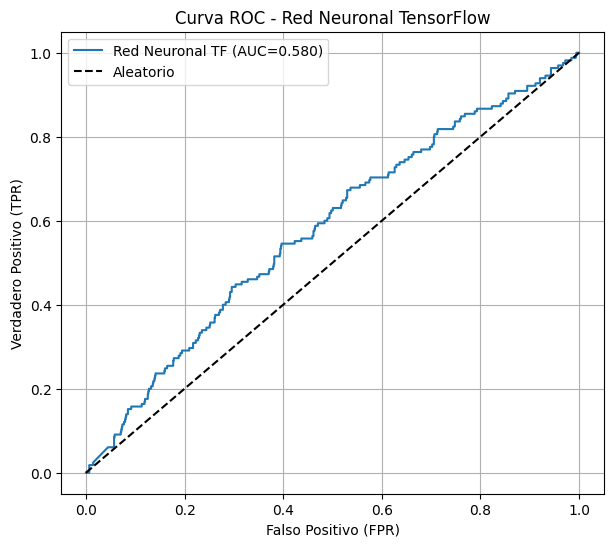

In [14]:
# --- Asumiendo que tienes definidas las variables ---
# top_hubs_in_expr y data_cox

# Preparar DataFrame para GAN con genes + variable objetivo
df_gan = data_cox[top_hubs_in_expr + ['survival_3yr']].copy()

# Entrenar CTGAN para generación sintética (si ya hecho, comentar para evitar repetir)
print("Entrenando CTGAN...")
ctgan = CTGAN(epochs=1000, verbose=True)
ctgan.fit(df_gan)

num_synthetic = df_gan.shape[0] * 10
synthetic_data = ctgan.sample(num_synthetic)

# Concatenar datos reales y sintéticos
df_augmented = pd.concat([df_gan, synthetic_data], ignore_index=True)

X = df_augmented[top_hubs_in_expr].values.astype(np.float32)
y = df_augmented['survival_3yr'].values.astype(np.int64)

# Crear la función para el modelo Keras
def create_model(input_dim):
    model = Sequential([
        Dense(64, input_shape=(input_dim,), activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[]
    )
    return model

# Estratificación para validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    print(f"\nFold {fold}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Balanced training set con SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    model = create_model(X.shape[1])

    # Directorio de logs para TensorBoard (uno por fold con timestamp)
    log_dir = os.path.join("runs", f"fold_{fold}", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    # Entrenamiento con TensorBoard callback
    model.fit(
        X_train_res, y_train_res,
        epochs=1000,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop, tensorboard_callback]
    )

    # Predicción en test
    y_proba = model.predict(X_test).flatten()
    auc_fold = roc_auc_score(y_test, y_proba)
    print(f"AUC Fold {fold}: {auc_fold:.4f}")
    auc_scores.append(auc_fold)

print(f"\nAUC promedio red neuronal (TF) con TensorBoard: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# Curva ROC del último fold
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'Red Neuronal TF (AUC={auc_scores[-1]:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Aleatorio')
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadero Positivo (TPR)")
plt.title("Curva ROC - Red Neuronal TensorFlow")
plt.legend()
plt.grid(True)
plt.show()

#tensorboard --logdir=runs

Entrenando CTGAN con datos de entrenamiento...


Gen. (-0.13) | Discrim. (-0.26): 100%|██████████| 10000/10000 [16:44<00:00,  9.95it/s]
d:\Coding\investigacionIA\entorno\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.0442 - val_loss: 2.9261
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9756 - val_loss: 2.8836
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9149 - val_loss: 2.8840
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8727 - val_loss: 2.8875
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8437 - val_loss: 2.8852
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8770 - val_loss: 2.8855
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8640 - val_loss: 2.8926
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8420 - val_loss: 2.8836
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8489 - val_loss: 2.8846
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8224 - val_loss: 2.8794
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8306 - val_loss: 2.8794
Epoch 12/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

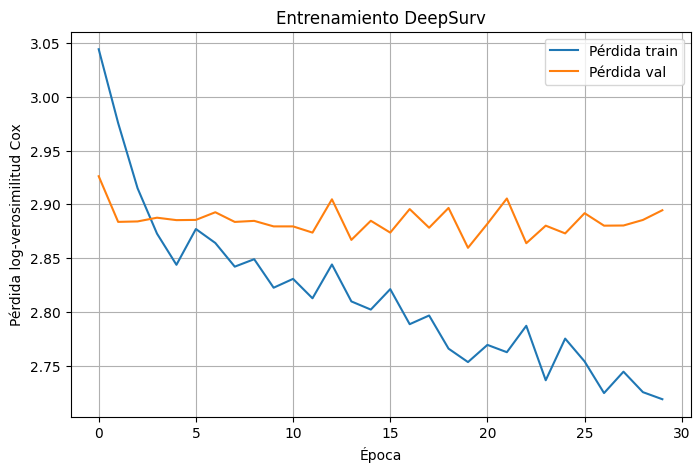

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from ctgan import CTGAN
import matplotlib.pyplot as plt

# 1. Seleccionar variables relevantes para GAN: genes hub + variables de supervivencia
df_for_gan = data_cox[top_hubs_in_expr + ['overall_survival', 'status']].copy()

# 2. Dividir en entrenamiento y test REAL separado para evaluación final
train_df, test_df = train_test_split(
    df_for_gan,
    test_size=0.2,
    stratify=data_cox['status'],  # estratificación por evento para preservar proporciones de censura
    random_state=42
)

# 3. Entrenar CTGAN solo con datos de entrenamiento (genes + tiempo + evento)
print("Entrenando CTGAN con datos de entrenamiento...")
ctgan = CTGAN(epochs=10000, verbose=True)

# Los datos contienen variables continuas (genes, tiempo) y variable categórica 'status'
# Definimos explícitamente columnas discretas
discrete_cols = ['status']

ctgan.fit(train_df, discrete_columns=discrete_cols)

# 4. Generar datos sintéticos (p.ej 2 veces más que train)
num_synth = len(train_df) * 5
synthetic_data = ctgan.sample(num_synth)

# 5. Concatenar datos reales de train + sintéticos para ampliar el set de entrenamiento
train_augmented_df = pd.concat([train_df, synthetic_data], ignore_index=True)

# 6. Preparar matrices X, tiempos y eventos para DeepSurv

# Variables de entrada: genes hub
X_train = train_augmented_df[top_hubs_in_expr].values.astype(np.float32)
times_train = train_augmented_df['overall_survival'].values.astype(np.float32)
events_train = train_augmented_df['status'].values.astype(np.float32)

X_test = test_df[top_hubs_in_expr].values.astype(np.float32)
times_test = test_df['overall_survival'].values.astype(np.float32)
events_test = test_df['status'].values.astype(np.float32)

# 7. Escalar variables predictoras (genes) con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Función de pérdida log-verosimilitud parcial Cox para TensorFlow

def neg_log_partial_likelihood(y_true, y_pred):
    times = y_true[:, 0]
    events = y_true[:, 1]

    order = tf.argsort(times, direction='DESCENDING')
    risk = tf.gather(y_pred, order)
    event = tf.gather(events, order)

    exp_risk = tf.exp(risk)
    cum_sum = tf.math.log(tf.math.cumsum(exp_risk))

    diff = risk - cum_sum
    diff_event = tf.boolean_mask(diff, event == 1)

    neg_log_lik = -tf.reduce_mean(diff_event)
    return neg_log_lik

# 9. Crear modelo DeepSurv: red neuronal feed-forward con salida lineal (log-risk)

def create_deepsurv_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # salida log-risk (sin activación)
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=neg_log_partial_likelihood)
    return model

model = create_deepsurv_model(X_train_scaled.shape[1])

# 10. Preparar etiquetas combinadas (tiempo + evento) para la función loss

y_train_loss = np.vstack([times_train, events_train]).T.astype(np.float32)

# 11. Entrenar el modelo con validación interna y early stopping

history = model.fit(
    X_train_scaled, y_train_loss,
    epochs=1000,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# 12. Evaluar el modelo en conjunto REAL de test

log_risk_test = model.predict(X_test_scaled).flatten()

c_index = concordance_index(times_test, -log_risk_test, events_test)
print(f"C-index (concordancia) en test real: {c_index:.4f}")

# 13. Visualizar curva de pérdida durante el entrenamiento

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida train')
plt.plot(history.history['val_loss'], label='Pérdida val')
plt.xlabel('Época')
plt.ylabel('Pérdida log-verosimilitud Cox')
plt.title('Entrenamiento DeepSurv')
plt.legend()
plt.grid(True)
plt.show()


## Prueba de Hiperparámetros con random forest

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

X = data_cox[top_hubs_in_expr].values
y = data_cox['survival_3yr'].values

# Definimos pipeline: balanceo + clasificador
pipeline = Pipeline([
    ('smotetomek', SMOTETomek(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Definir búsqueda de hiperparámetros (puedes agregar más combinaciones)
param_grid = {
    'rf__n_estimators': [100, 200, 500],
    'rf__max_depth': [None, 5, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False]
}

# Función scoring segura para AUC (evita nan en folds con una sola clase)
def safe_roc_auc_score(y_true, y_pred_proba):
    unique_classes = np.unique(y_true)
    if len(unique_classes) < 2:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred_proba)

scorer = make_scorer(safe_roc_auc_score, needs_proba=True)

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    verbose=2,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

#grid_search.fit(X, y)

#print(f"Mejores parámetros: {grid_search.best_params_}")
#print(f"Mejor AUC medio (CV): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


KeyboardInterrupt: 

In [ ]:
import pandas as pd

#results = pd.DataFrame(grid_search.cv_results_)

# Ordenar por mejor score medio
#top_results = results.sort_values(by='mean_test_score', ascending=False).head(3)

#for idx, row in top_results.iterrows():
    print(f"Configuración:\n{row['params']}")
    print(f"AUC medio (CV): {row['mean_test_score']:.4f}")
    fold_scores = [row[f'split{i}_test_score'] for i in range(cv.get_n_splits())]
    for fold_i, score in enumerate(fold_scores, 1):
        print(f"  Fold {fold_i}: AUC = {score:.4f}")
    print("-" * 40)


In [ ]:
from sklearn.base import clone

best_params = grid_search.best_params_

pipeline.set_params(**best_params)

auc_scores = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Clonar pipeline con mejores parámetros para evitar contaminación
    model = clone(pipeline)
    
    # Entrenar con balanceo SMOTETomek en train
    model.fit(X_train, y_train)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)
    print(f"Fold {fold}: AUC = {auc:.4f}")

print(f"AUC promedio con mejores parámetros: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
